In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv("../data/train.csv")
n, m = df.shape

print(df.head(5))

print(f'dims: {n} x {m}')

   ID  log_pSat_Pa          MW  NumOfAtoms  NumOfC  NumOfO  NumOfN  \
0   0   -11.295070  224.016832          23       6       9       0   
1   1    -4.782500  310.064845          35       9      10       2   
2   2    -6.204319  368.033938          37      10      13       2   
3   3    -9.672591  299.012475          29       7      12       1   
4   4    -4.252058  202.011353          20       7       7       0   

   NumHBondDonors  NumOfConf  NumOfConfUsed  ... ester  ether (alicyclic)  \
0               4      485.0           40.0  ...     0                  1   
1               1      236.0           40.0  ...     0                  0   
2               1      308.0           40.0  ...     0                  0   
3               4      769.0            3.0  ...     0                  0   
4               1       77.0           32.0  ...     0                  1   

   nitrate  nitro  aromatic hydroxyl  carbonylperoxynitrate  peroxide  \
0        0      0                  0       

In [4]:
nans_df = df.loc[:, df.isna().any()]
nans_count = nans_df.isna().sum()
nans_proportion = nans_count / n
result = pd.DataFrame({
    "nan": nans_count,
    "prop": nans_proportion
})


print(result)

               nan      prop
parentspecies  210  0.007884


Text(0.5, 0, 'val')

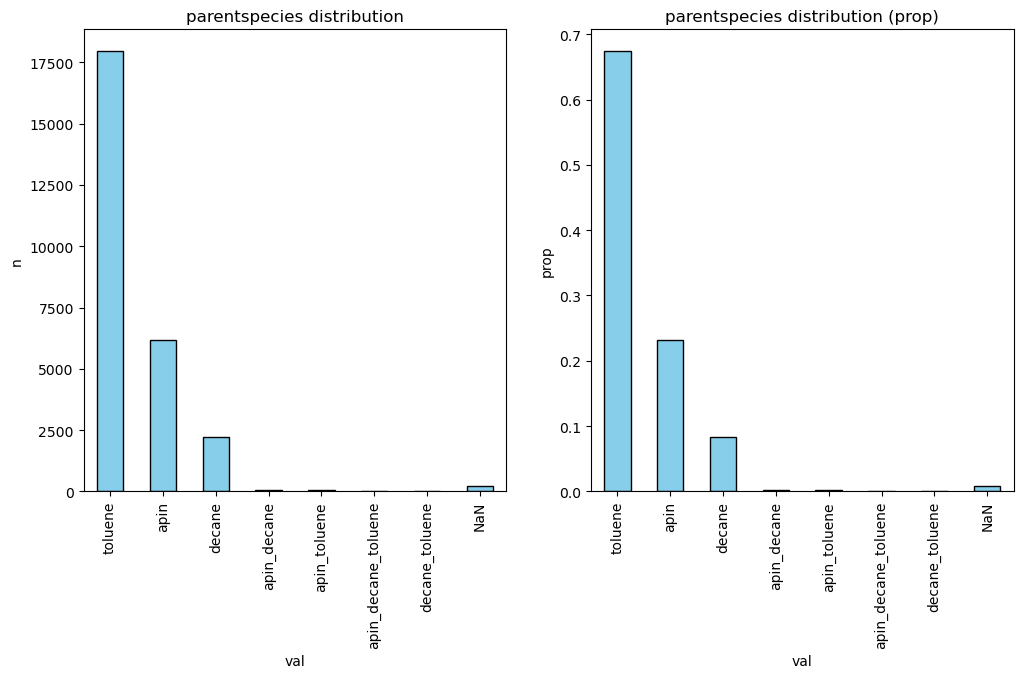

In [5]:
value_counts = df['parentspecies'].value_counts(dropna=True)
nan_count = df['parentspecies'].isna().sum()
distribution = pd.concat([value_counts, pd.Series({'NaN': nan_count})])
proportions = distribution / len(df)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

distribution.plot(kind='bar', ax=ax[0],color='skyblue', edgecolor='black')
ax[0].set_ylabel('n')
ax[0].set_title('parentspecies distribution')
ax[0].set_xlabel('val')

proportions.plot(kind='bar', ax=ax[1],color='skyblue', edgecolor='black')
ax[1].set_ylabel('prop')
ax[1].set_title('parentspecies distribution (prop)')
ax[1].set_xlabel('val')


In [6]:
top_3_values = df['parentspecies'].value_counts().head(3)
top_3_values_prob = top_3_values / top_3_values.sum()

def impute_proportional(x):
    if pd.isna(x):
        return np.random.choice(top_3_values.index, p=top_3_values_prob)
    else:
        return x
        
df_imputed = df.copy()
df_imputed['parentspecies'] = df_imputed['parentspecies'].apply(impute_proportional)

print(df_imputed['parentspecies'].isna().sum()) # should be 0

0


In [7]:
X = df.drop(columns=['log_pSat_Pa', 'ID'])
y = df['log_pSat_Pa']

print(X.dtypes)
print(X.describe())
y.describe() # NumOfComf distribution seems weird

MW                              float64
NumOfAtoms                        int64
NumOfC                            int64
NumOfO                            int64
NumOfN                            int64
NumHBondDonors                    int64
NumOfConf                       float64
NumOfConfUsed                   float64
parentspecies                    object
C=C (non-aromatic)                int64
C=C-C=O in non-aromatic ring      int64
hydroxyl (alkyl)                  int64
aldehyde                          int64
ketone                            int64
carboxylic acid                   int64
ester                             int64
ether (alicyclic)                 int64
nitrate                           int64
nitro                             int64
aromatic hydroxyl                 int64
carbonylperoxynitrate             int64
peroxide                          int64
hydroperoxide                     int64
carbonylperoxyacid                int64
nitroester                        int64


count    26637.000000
mean        -5.516747
std          3.120191
min        -18.822563
25%         -7.515147
50%         -5.450577
75%         -3.429192
max          8.390642
Name: log_pSat_Pa, dtype: float64

In [8]:
label_encoder = LabelEncoder()
X['parentspecies'] = label_encoder.fit_transform(X['parentspecies'])

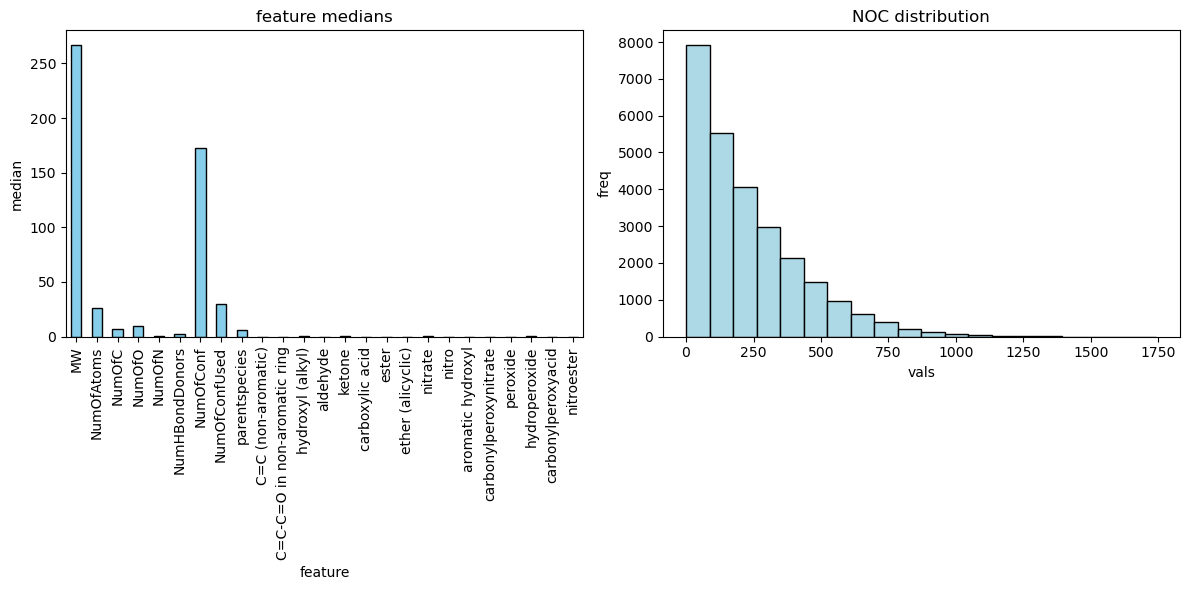

In [9]:
median_values = X.median()
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

median_values.plot(kind='bar', ax=ax[0], color='skyblue', edgecolor='black')
ax[0].set_title('feature medians')
ax[0].set_xlabel('feature')
ax[0].set_ylabel('median')

df['NumOfConf'].plot(kind='hist', bins=20, ax=ax[1], color='lightblue', edgecolor='black')
ax[1].set_title('NOC distribution')
ax[1].set_xlabel('vals')
ax[1].set_ylabel('freq')

plt.tight_layout()
plt.show()

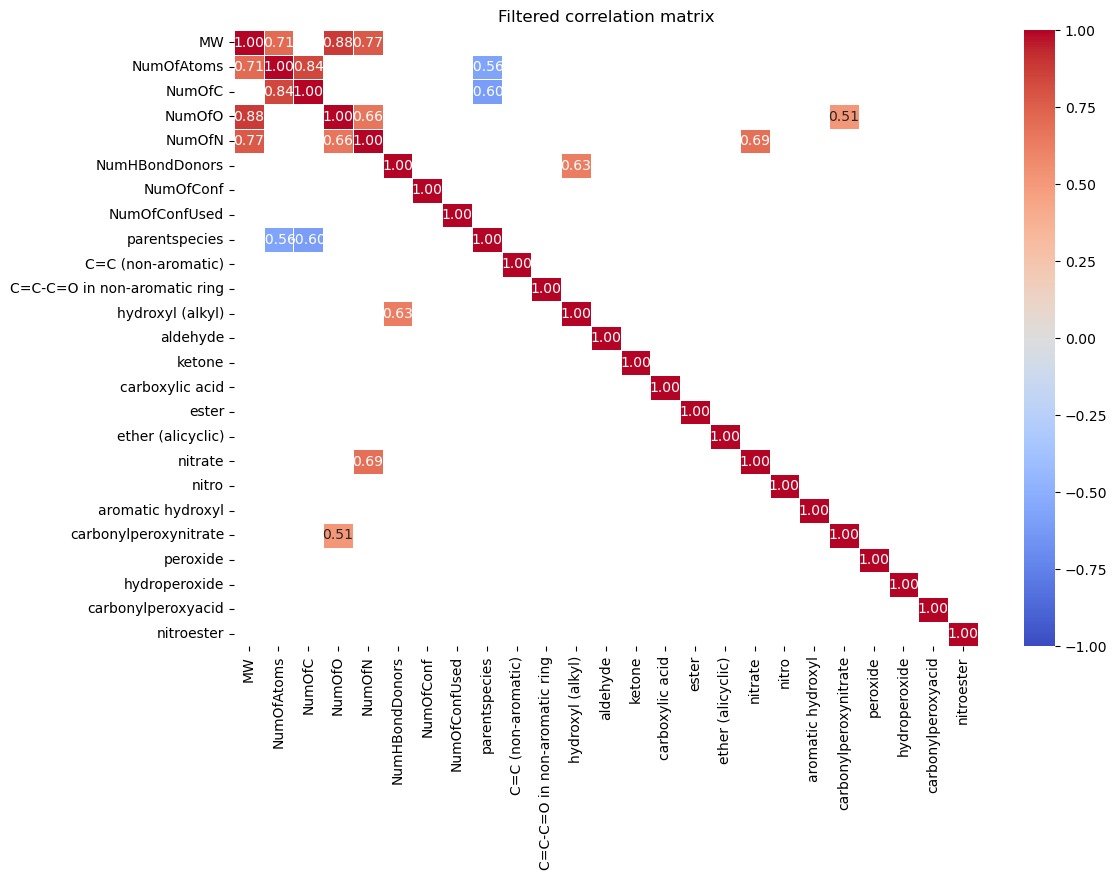

In [10]:
corr_matrix = X.corr()
mask = (corr_matrix.abs() > 0.5)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[mask], annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Filtered correlation matrix')
plt.show()

In [11]:
X_const = add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif_data)

/Users/antti.immonen/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
                         feature         VIF
0                          const  109.079202
1                             MW         inf
2                     NumOfAtoms         inf
3                         NumOfC         inf
4                         NumOfO         inf
5                         NumOfN         inf
6                 NumHBondDonors         inf
7                      NumOfConf    3.243523
8                  NumOfConfUsed    1.895979
9                  parentspecies    2.961237
10            C=C (non-aromatic)    2.145305
11  C=C-C=O in non-aromatic ring    1.191147
12              hydroxyl (alkyl)         inf
13                      aldehyde   10.293830
14                        ketone   18.013132
15               carboxylic acid         inf
16                         ester   12.

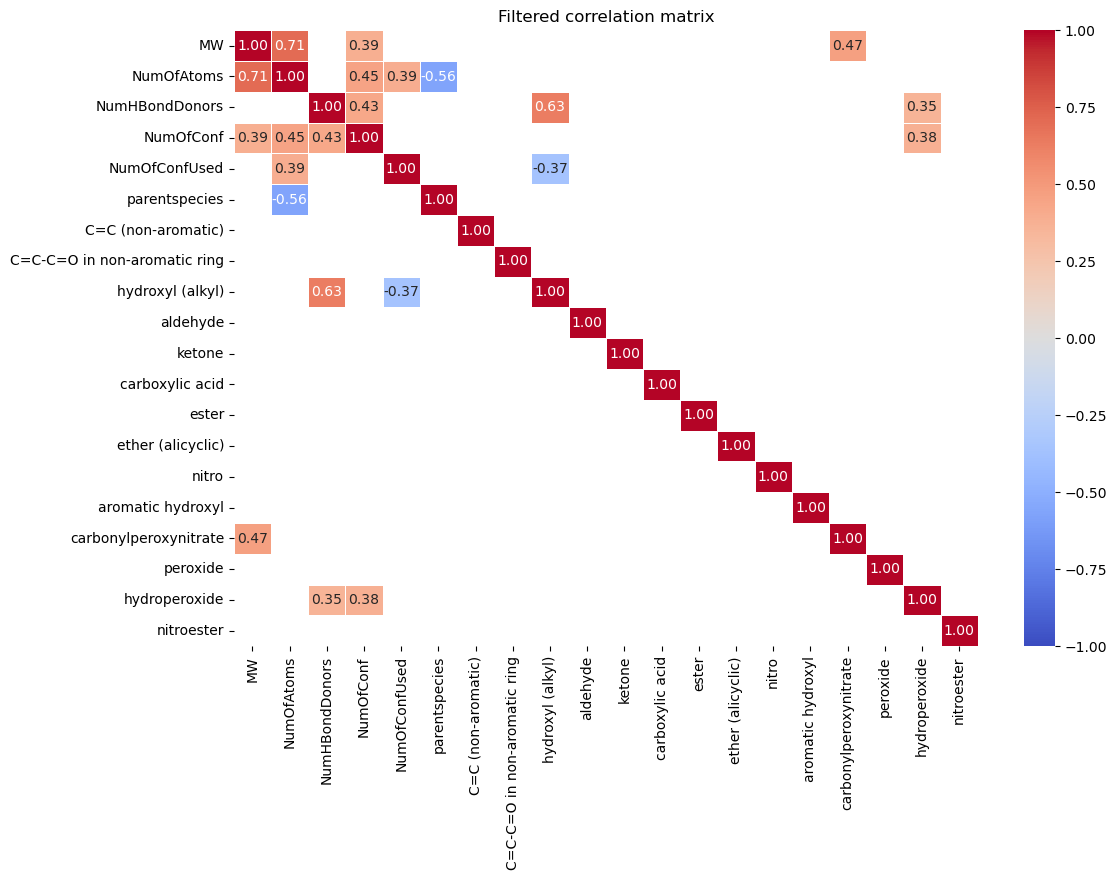

                         feature        VIF
0                          const  96.086883
1                             MW   5.757573
2                     NumOfAtoms   6.591967
3                 NumHBondDonors   8.880680
4                      NumOfConf   2.516376
5                  NumOfConfUsed   1.792391
6                  parentspecies   2.868248
7             C=C (non-aromatic)   1.305419
8   C=C-C=O in non-aromatic ring   1.169632
9               hydroxyl (alkyl)   5.694497
10                      aldehyde   1.445994
11                        ketone   1.690641
12               carboxylic acid   2.261917
13                         ester   1.896264
14             ether (alicyclic)   2.413073
15                         nitro   1.331348
16             aromatic hydroxyl   1.018956
17         carbonylperoxynitrate   2.080206
18                      peroxide   2.630081
19                 hydroperoxide   3.729650
20                    nitroester   1.148942


In [17]:
cols = ['NumOfC', 'NumOfO', 'NumOfN', 'nitrate', 'carbonylperoxyacid']
X_reduced = X.drop(columns=cols)
corr_matrix_reduced = X_reduced.corr()
mask_reduced = (corr_matrix_reduced.abs() > 0.35)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_reduced[mask_reduced], annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Filtered correlation matrix')
plt.show()

X_const_reduced = add_constant(X_reduced)

vif_data_reduced = pd.DataFrame()
vif_data_reduced["feature"] = X_const_reduced.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(X_const_reduced.values, i) for i in range(X_const_reduced.shape[1])]

print(vif_data_reduced)


In [20]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

cols = ['NumOfC', 'NumOfO', 'NumOfN', 'nitrate', 'carbonylperoxyacid']

train_reduced = train_df.drop(columns=cols)
test_reduced = test_df.drop(columns=cols)

train_reduced.to_csv('../data/train_reduced.csv', index=False)
test_reduced.to_csv('../data/test_reduced.csv', index=False)

print(train_reduced.head())
print(test_reduced.head())

   ID  log_pSat_Pa          MW  NumOfAtoms  NumHBondDonors  NumOfConf  \
0   0   -11.295070  224.016832          23               4      485.0   
1   1    -4.782500  310.064845          35               1      236.0   
2   2    -6.204319  368.033938          37               1      308.0   
3   3    -9.672591  299.012475          29               4      769.0   
4   4    -4.252058  202.011353          20               1       77.0   

   NumOfConfUsed parentspecies  C=C (non-aromatic)  \
0           40.0       toluene                   0   
1           40.0          apin                   0   
2           40.0          apin                   0   
3            3.0       toluene                   0   
4           32.0       toluene                   0   

   C=C-C=O in non-aromatic ring  ...  ketone  carboxylic acid  ester  \
0                             0  ...       0                1      0   
1                             0  ...       1                0      0   
2                   